# Julia Sets Mini-Benchmark

We can see how a julia function compares to a Python function by calling Python from julia.

First we import the Python function we have written using the PyCall module

In [2]:
run(`wget https://raw.githubusercontent.com/josh-gree/juliafiles/f9eb5d5a321712c186b8b5f711651328760b9c3a/dat.txt`)
run(`wget https://raw.githubusercontent.com/josh-gree/juliafiles/f9eb5d5a321712c186b8b5f711651328760b9c3a/julia.c`)
run(`wget https://raw.githubusercontent.com/josh-gree/juliafiles/f9eb5d5a321712c186b8b5f711651328760b9c3a/juliaset.py`)

--2015-05-04 15:42:44--  http://southampton.ac.uk/~jdg1g14/dat.txt
Resolving southampton.ac.uk... 152.78.118.52
Connecting to southampton.ac.uk|152.78.118.52|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://www.southampton.ac.uk/~jdg1g14/dat.txt [following]
--2015-05-04 15:42:44--  http://www.southampton.ac.uk/~jdg1g14/dat.txt
Resolving www.southampton.ac.uk... 152.78.118.52
Reusing existing connection to southampton.ac.uk:80.
HTTP request sent, awaiting response... 302 Found
Location: http://www.southampton.ac.uk/inf/tools/error/403.html [following]
--2015-05-04 15:42:44--  http://www.southampton.ac.uk/inf/tools/error/403.html
Reusing existing connection to southampton.ac.uk:80.
HTTP request sent, awaiting response... 200 OK
Length: 6119 (6.0K) [text/html]
Saving to: 'dat.txt.2'

     0K .....                                                 100% 2.99M=0.002s

2015-05-04 15:42:44 (2.99 MB/s) - 'dat.txt.2' saved [6119/6119]

--2015-05-04 1

In [12]:
using PyCall
unshift!(PyVector(pyimport("sys")["path"]),""); # append current directory to system path in order to import local python module

@pyimport juliaset as juliaset # import module -> must give it a name!

Here is the contents of the .py we have imported

In [13]:
run(`cat juliaset.py`) # contents of juliaset.py

def julia_set(z, c, maxit=2000):
    for n in range(1,maxit+1):
        if abs(z) > 4:
            return n-1
        z = z*z+c
    return maxit


We can wrap a C function

In [14]:
run(`cat julia.c`)

#include<stdlib.h>
#include<stdio.h>

 int julia(double Zre, double Zim, double Cre, double Cim,int maxit)
 {
 	double new_Zre;
 	double new_Zim;

 	for (int i = 0; i < maxit; ++i)
 	{
 		new_Zre = Zre;
 		new_Zim = Zim;

 		Zre = new_Zre*new_Zre - new_Zim*new_Zim + Cre;
 		Zim = 2*new_Zim*new_Zre + Cim;

 		if ((Zre*Zre + Zim*Zim)>4)	
 		{
 			return i;
 		}

 	}
 	return maxit;
 }

Compile from the notebook

In [15]:
run(`gcc julia.c -O3 -shared -o julia`)

Create julia function that calls the compiled C code

In [16]:
julia_C(z,c) = ccall((:julia, "./julia"),Cint,(Cdouble,Cdouble,Cdouble,Cdouble,Cint),z.re,z.im,c.re,c.im,2000)

julia_C (generic function with 1 method)

Now we define a similar julia function

In [17]:
# define julia function for julia set
function julia(z,c;maxit = 2000)
    for n = 1:maxit + 1
        if abs(z) > 4
            return n-1
        end
        z = z*z + c
    end
end

julia (generic function with 1 method)

Using the @time macro we can now compare the performance of the two functions in a large list comprehension

In [18]:
@time image_python = [juliaset.julia_set(c+d*im,-0.4+0.6*im) for c = linspace(-1,1,1001), d = linspace(-1.5,1.5,1001)];

elapsed time: 35.411919031 seconds (617348776 bytes allocated, 9.51% gc time)


In [19]:
@time image_C = [julia_C(c+d*im,-0.4+0.6*im) for c = linspace(-1,1,1001), d = linspace(-1.5,1.5,1001)];

elapsed time: 0.12463375 seconds (4024224 bytes allocated)


In [20]:
@time image_julia = [julia(c+d*im,-0.4+0.6*im) for c = linspace(-1,1,1001), d = linspace(-1.5,1.5,1001)];

elapsed time: 0.503684011 seconds (24056736 bytes allocated)


Now we plot using the PyPlot module

In [21]:
using PyPlot

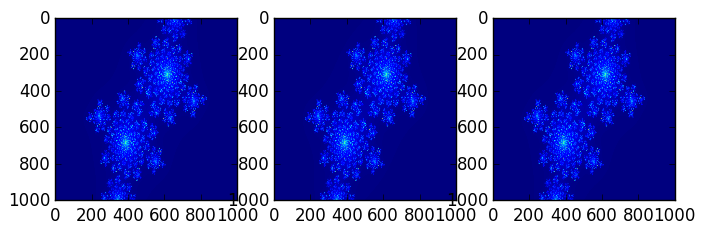

PyObject <matplotlib.image.AxesImage object at 0x11e692690>

In [22]:
subplot(1,3,1)
imshow(image_python)
subplot(1,3,2)
imshow(image_C)
subplot(1,3,3)
imshow(image_julia)